#### Poisson Equation in 2D

In [1]:
from subprocess import run
import time
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit

from poisson import Poisson2D
import subprocess

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ref_func(x, y):
    return y*(1-y)*x**3

def source_term(x, y):
    return 6*x*y*(1-y)-2*x**3

def linear_model(x, a, b):
    return a * x + b

!mpirun -np 4 python poisson.py


'mpirun' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


The figure below is what analytical solution looks like under a 512-by-512 grid.

CUDA blocks set to: 4, threads set to: 32


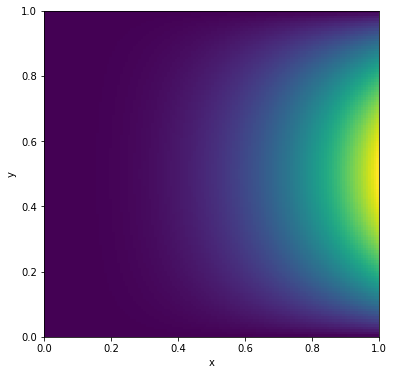

In [3]:
N=128
poisson = Poisson2D(N=N)

x = poisson.x

ref = ref_func(x[:, None], x[None, :])
fig = plt.figure(figsize=(6, 6))
fig.gca().pcolormesh(np.linspace(0, 1, N+1), np.linspace(0, 1, N+1), ref.T)
fig.gca().set_xlabel("x")
fig.gca().set_ylabel("y")
plt.show()

In [114]:
# schemes = ["CG", "Gauss-Seidel", "SOR"]
schemes = ["CG-CPU"]
resolution = np.array([32])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:
    error = []
    iters = []
    wall_time = []

    for N in resolution:
        poisson = Poisson2D(N=N)

        x = poisson.x
        ref = ref_func(x[:, None], x[None, :])
        BC = np.zeros((N+2, N+2))
        BC[-1, 1:-1] = x * (1 - x)
        source = source_term(x[:, None], x[None, :])

        if scheme == "SOR":
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None,
                        BC=BC, source=source,
                        w=1.6905, terminate=1e-12)
            t2 = time.time()
        else:
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=BC,
                        source=source, terminate=1e-12)
            t2 = time.time()

        error.append(np.abs(poisson.u[1:-1, 1:-1] - ref).sum() / N**2)
        print(error)
        iters.append(poisson.steps)
        wall_time.append(t2 - t1)

    error_all.append(error)
    iters_all.append(iters)
    wall_time_all.append(wall_time)

[0.0016791297899653333]


32


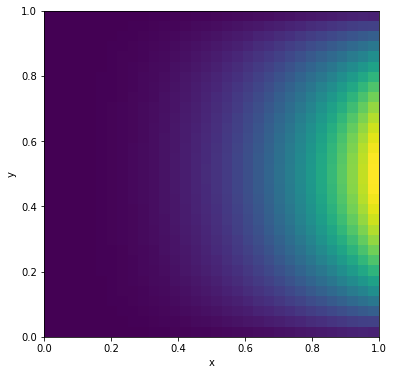

In [115]:
sol = poisson.u[1:-1, 1:-1]
print(resolution[-1])

fig = plt.figure(figsize=(6, 6))
fig.gca().pcolormesh(np.linspace(0, 1, resolution[-1]+1), np.linspace(0, 1, resolution[-1]+1), sol.T)
fig.gca().set_xlabel("x")
fig.gca().set_ylabel("y")
plt.show()

# compiler Compare solution with C++ version

In [83]:
# modify the string below to use your compiler
compiler = "C:/TDM-GCC-64/bin/g++.exe"
# compiler="g++"

run(f"{compiler} -fopenmp CGPoisson.cpp -o CGPoisson.out -lstdc++", shell=True)

CompletedProcess(args='C:/TDM-GCC-64/bin/g++.exe -fopenmp CGPoisson.cpp -o CGPoisson.out -lstdc++', returncode=0)

In [84]:
for N in resolution:
    poisson = Poisson2D(N=N)
    x = poisson.x
    dx = poisson.dx
    BC = np.zeros((N+2, N+2))
    BC[-1, 1:-1] = x * (1 - x)

    source = source_term(x[:, None], x[None, :])

    init_cond = BC
    init_cond[1:-1, 1:-1] = source

    np.savetxt(f"boundary_source_{N}.dat", init_cond.reshape(1, -1), "%.18f")

    run(f".\\CGPoisson.out .\\boundary_source_{N}.dat", shell=True)

2


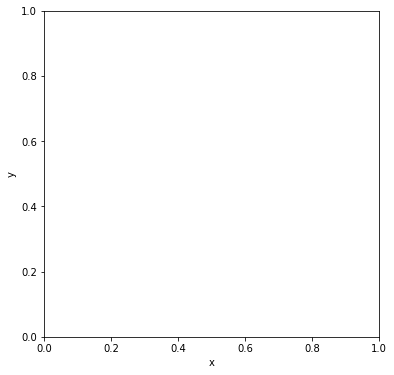

4


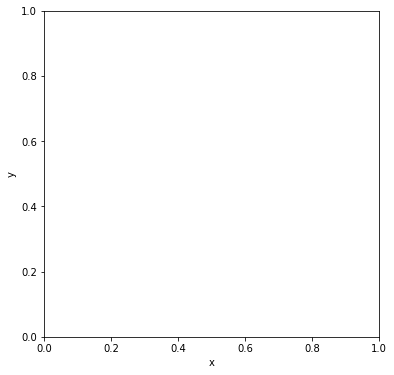

8


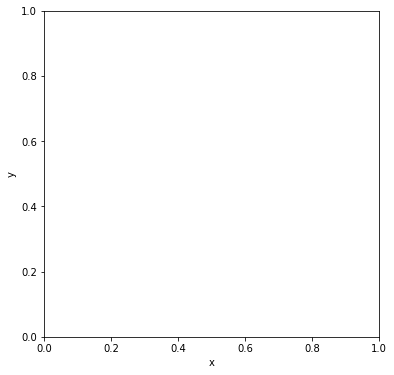

16


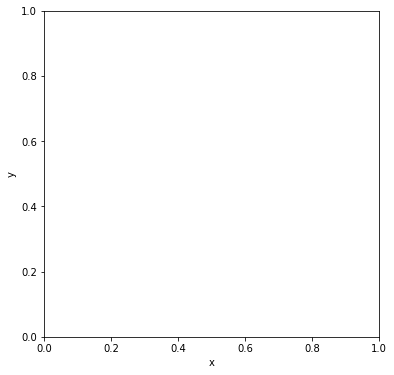

32


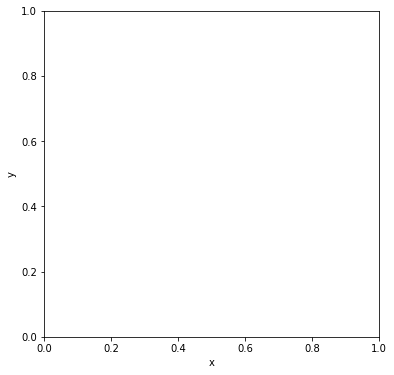

64


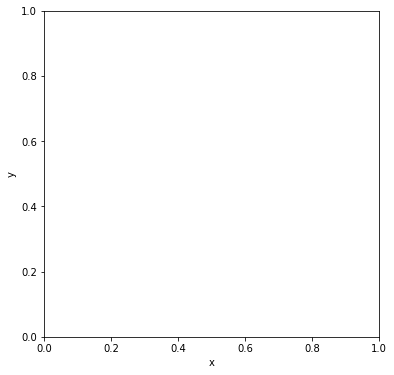

128


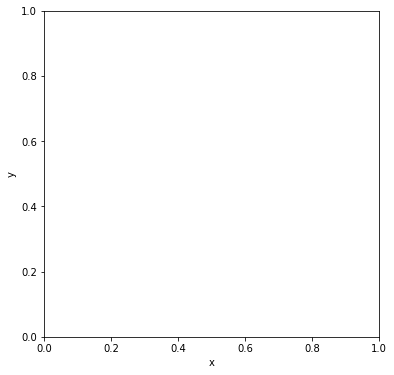

In [85]:
for N in resolution[:-2]:
    sol = np.loadtxt(f"output_{N}.txt")
    N_sol = int(np.sqrt(sol.shape)[0])
    sol_plot = sol.reshape(-1, N_sol, order='C')[1:-1, 1:-1]
    print(N_sol-2)

    fig = plt.figure(figsize=(6, 6))
    fig.gca().pcolormesh(np.linspace(0, 1, N_sol-1), np.linspace(0, 1, N_sol-1), sol_plot.T)
    fig.gca().set_xlabel("x")
    fig.gca().set_ylabel("y")
    plt.show()

Compare the scaling between spatial resolutions and errors, iterations required and wall times required.

The scaling between resolutions and errors is expected to be (inversely) second-order. However, as shown in the first figure below, I get a scaling of (inversely) first order.

As shown in the second figure below, the scaling between resolutions and iterations required for convergence is close to second order.

As shown in the third figure below, the scaling between resolutions and wall-time required for convergence is close to fourth order.

#### Compare CG with Gauss-Sidual & SOR

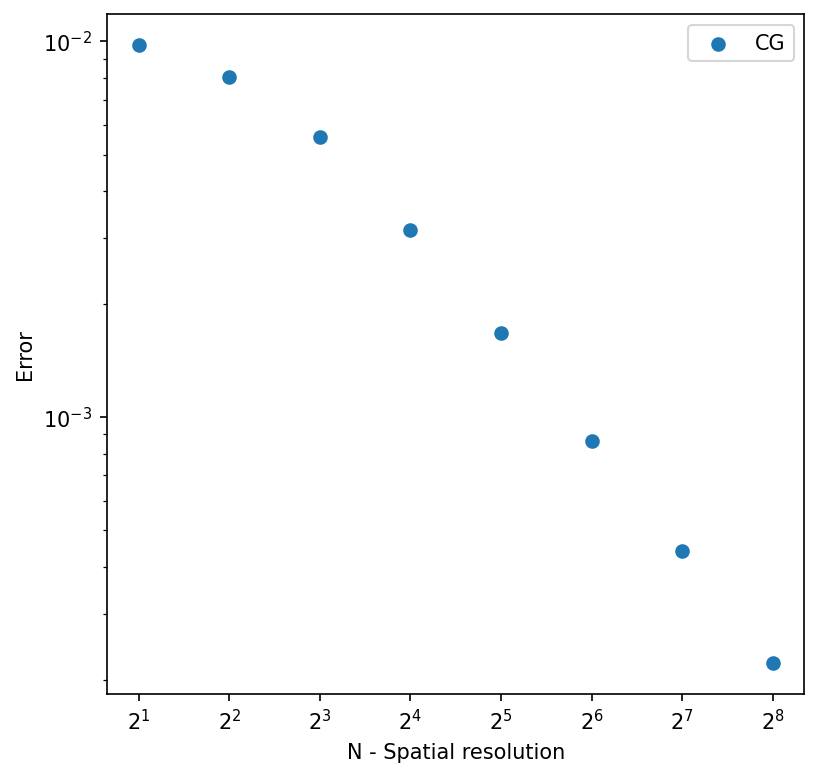

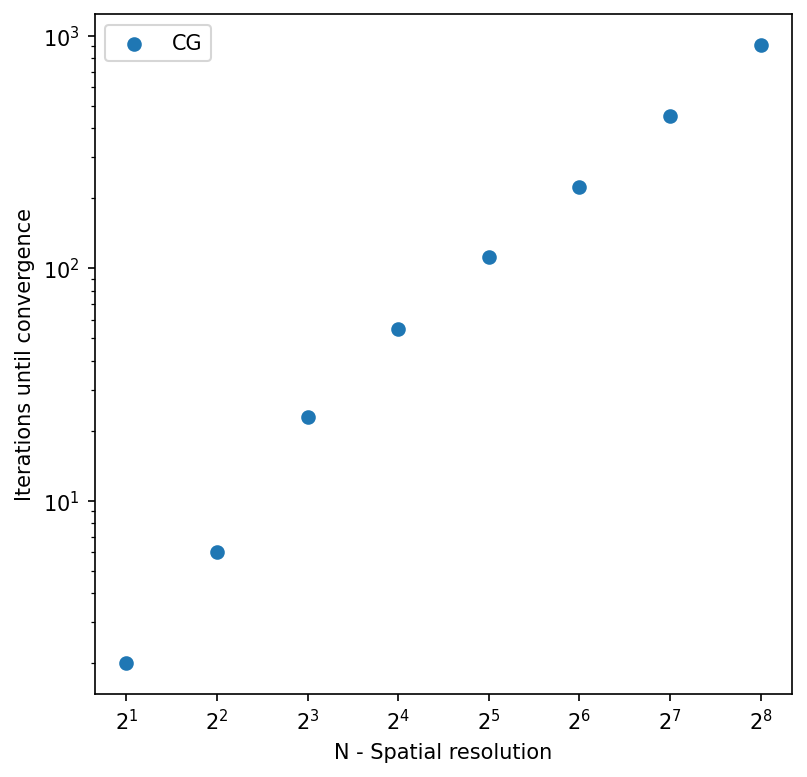

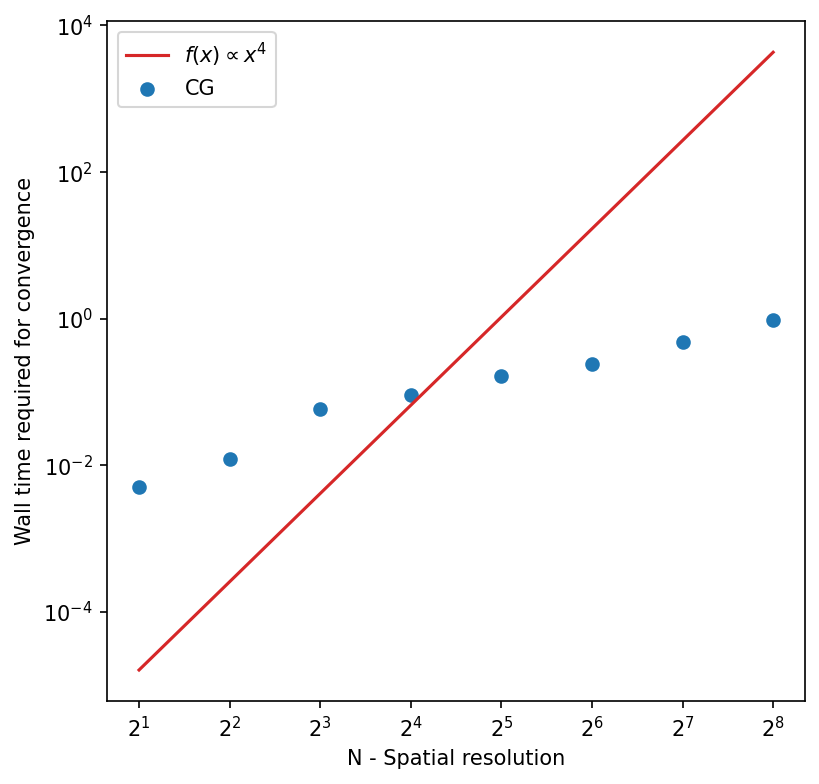

In [ ]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)

for i, err in enumerate(error_all):
    fig1.gca().scatter(np.array(resolution)*(1+0.01*i), err, label=schemes[i])
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution, iter, label=schemes[i])
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")

for i, _wall_time in enumerate(wall_time_all):
    fig3.gca().scatter(resolution, _wall_time, label=schemes[i])
    fig3.gca().set_yscale("log", base=10)
    fig3.gca().set_xscale("log", base=2)
    fig3.gca().set_xlabel("N - Spatial resolution")
    fig3.gca().set_ylabel("Wall time required for convergence")


res = np.linspace(resolution[0], resolution[-1], 1000)
#fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
# fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
# fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
# fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()

#### CPU parallelize vs GPU parallelize

In [3]:
schemes = [ "CG-MPI","CG"]
resolution = np.array([2,4,8,16,32,64,128,256, 512])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:
    for device in ['cpu_1thread','cpu', 'cuda']:
        print(scheme, device)
        error = []
        iters = []
        wall_time = []

        for N in resolution:
            poisson = Poisson2D(N=N, device=device)

            x = poisson.x
            ref = ref_func(x[:, None], x[None, :])
            BC = np.zeros((N + 2, N + 2))
            BC[-1, 1:-1] = x * (1 - x)
            source = source_term(x[:, None], x[None, :])

            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=BC, source=source, terminate=1e-12)
            t2 = time.time()

            error.append(np.abs(poisson.u[1:-1, 1:-1] - ref).sum() / N ** 2)
            print(error)
            iters.append(poisson.steps)
            wall_time.append(t2 - t1)

        error_all.append(error)
        iters_all.append(iters)
        wall_time_all.append(wall_time)

CG-MPI cpu_1thread
Number of threads set to: 1
[0.009765625000000002]
Number of threads set to: 1
[0.009765625000000002, 0.008056640624999997]
Number of threads set to: 1
[0.009765625000000002, 0.008056640624999997, 0.005581530987082186]
Number of threads set to: 1
[0.009765625000000002, 0.008056640624999997, 0.005581530987082186, 0.0031432680088152648]
Number of threads set to: 1
[0.009765625000000002, 0.008056640624999997, 0.005581530987082186, 0.0031432680088152648, 0.001679129789963737]
Number of threads set to: 1
[0.009765625000000002, 0.008056640624999997, 0.005581530987082186, 0.0031432680088152648, 0.001679129789963737, 0.0008661596726101974]
Number of threads set to: 1
[0.009765625000000002, 0.008056640624999997, 0.005581530987082186, 0.0031432680088152648, 0.001679129789963737, 0.0008661596726101974, 0.000440029026397109]
Number of threads set to: 1
[0.009765625000000002, 0.008056640624999997, 0.005581530987082186, 0.0031432680088152648, 0.001679129789963737, 0.00086615967261

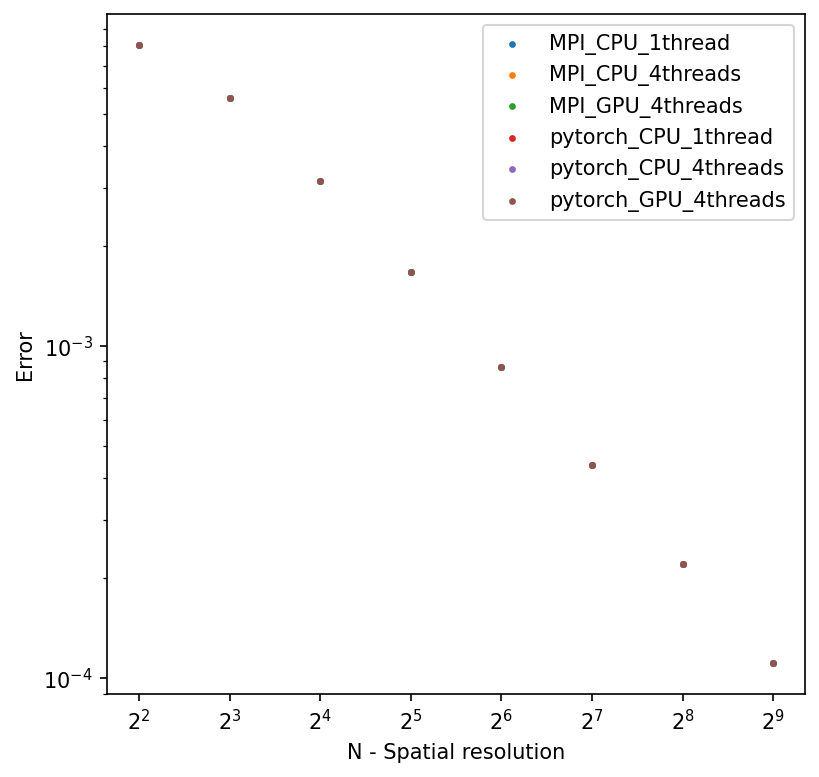

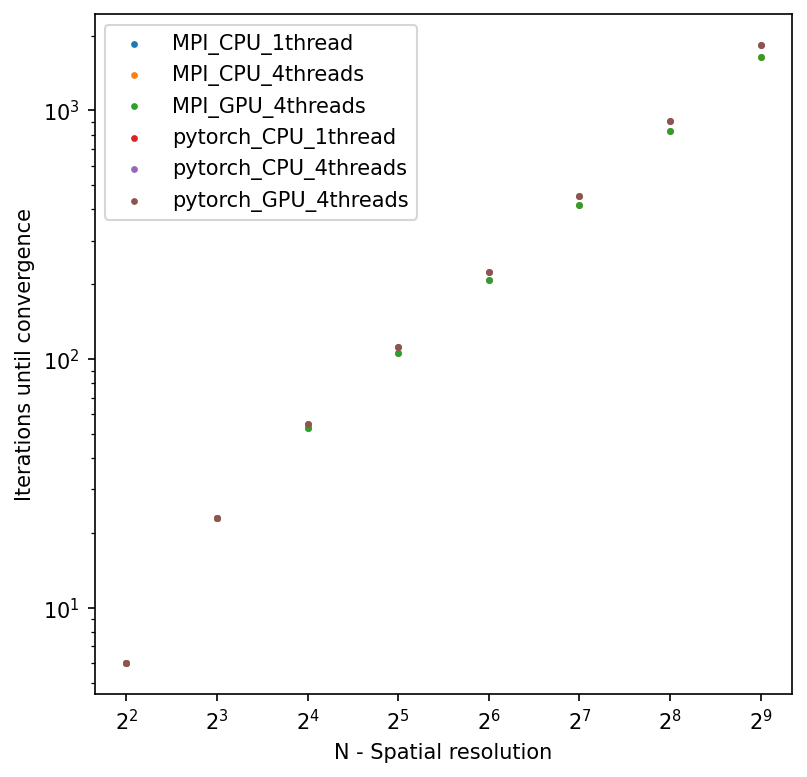

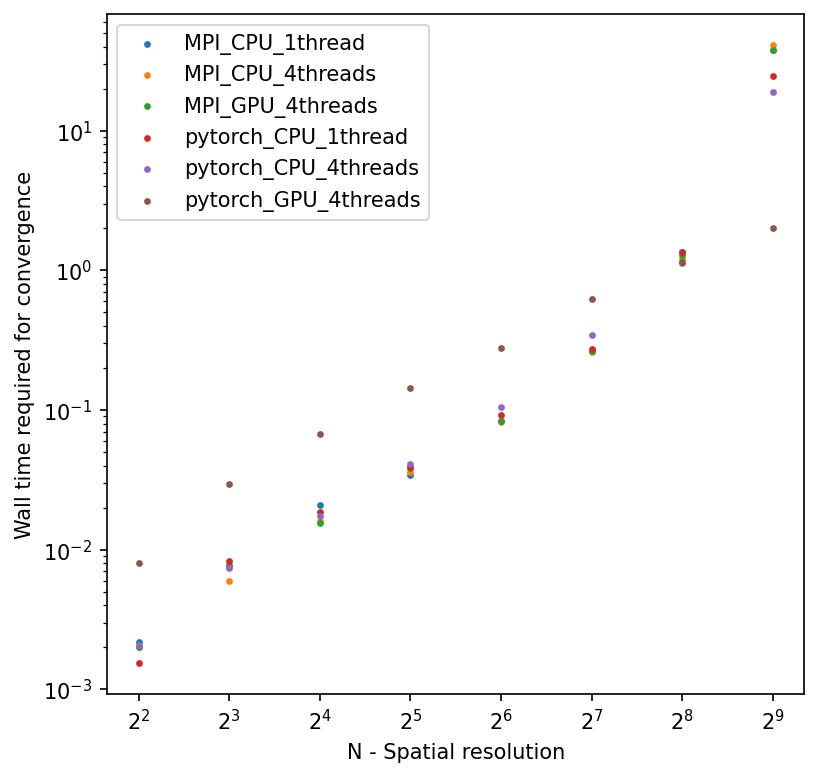

In [4]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)
para = [ 'MPI_CPU_1thread','MPI_CPU_4threads','MPI_GPU_4threads', 'pytorch_CPU_1thread', 'pytorch_CPU_4threads','pytorch_GPU_4threads']
for i, err in enumerate(error_all):
    fig1.gca().scatter(resolution[1:], err[1:], label=para[i], s = 5)
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution[1:], iter[1:], label=para[i], s = 5)
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")

for i, _wall_time in enumerate(wall_time_all):
    fig3.gca().scatter(resolution[1:], _wall_time[1:], label=para[i], s = 5)
    fig3.gca().set_yscale("log", base=10)
    fig3.gca().set_xscale("log", base=2)
    fig3.gca().set_xlabel("N - Spatial resolution")
    fig3.gca().set_ylabel("Wall time required for convergence")


res = np.linspace(resolution[0], resolution[-1], 1000)
#fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
# fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
# fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
# fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
# fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()

#### CPU parallelize vs GPU parallelize vs CPU serial

In [6]:
schemes = ["CG-MPI","CG", "CG-CPU" ]
resolution = np.array([4, 8, 16, 32, 64, 128])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:
    if scheme == 'CG' or scheme == 'CG-MPI':
        print(scheme)
        for device in ['cpu_1thread','cpu', 'cuda']:
            print(device)
            error = []
            iters = []
            wall_time = []

            for N in resolution:
                poisson = Poisson2D(N=N, device=device)

                x = poisson.x
                ref = ref_func(x[:, None], x[None, :])
                BC = np.zeros((N + 2, N + 2))
                BC[-1, 1:-1] = x * (1 - x)
                source = source_term(x[:, None], x[None, :])

                t1 = time.time()
                poisson.run(scheme=scheme, steps=None, BC=BC, source=source, terminate=1e-12)
                t2 = time.time()

                error.append(np.abs(poisson.u[1:-1, 1:-1] - ref).sum() / N ** 2)
                
                iters.append(poisson.steps)
                wall_time.append(t2 - t1)
            print(error)
            error_all.append(error)
            iters_all.append(iters)
            wall_time_all.append(wall_time)
    else:
        print('test')
        error = []
        iters = []
        wall_time = []
        for N in resolution:
            poisson = Poisson2D(N=N)
            x = poisson.x
            ref = ref_func(x[:, None], x[None, :])
            BC = np.zeros((N+2, N+2))
            BC[-1, 1:-1] = x*(1-x)
            source = source_term(x[:, None], x[None, :])
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=BC, source=source, terminate=1e-12)
            t2 = time.time()

            error.append(np.abs(poisson.u[1:-1, 1:-1]-ref).sum()/N**2)
            iters.append(poisson.steps)
            wall_time.append(t2-t1)
        print(error)
        error_all.append(error)
        iters_all.append(iters)
        wall_time_all.append(wall_time)

CG-MPI
cpu_1thread
Number of threads set to: 1
Number of threads set to: 1
Number of threads set to: 1
Number of threads set to: 1
Number of threads set to: 1
Number of threads set to: 1
[0.008056640624999997, 0.005581530987082186, 0.0031432680088152648, 0.001679129789963737, 0.0008661596726101974, 0.000440029026397109]
cpu
Number of threads set to: 4
Number of threads set to: 4
Number of threads set to: 4
Number of threads set to: 4
Number of threads set to: 4
Number of threads set to: 4
[0.008056640624999997, 0.005581530987082186, 0.0031432680088152648, 0.001679129789963737, 0.0008661596726101974, 0.000440029026397109]
cuda
CUDA blocks set to: 1, threads set to: 32
CUDA blocks set to: 2, threads set to: 32
CUDA blocks set to: 4, threads set to: 32
CUDA blocks set to: 8, threads set to: 32
CUDA blocks set to: 16, threads set to: 32
CUDA blocks set to: 32, threads set to: 32
[0.008056640624999997, 0.005581530987082186, 0.0031432680088152648, 0.001679129789963737, 0.0008661596726101974,

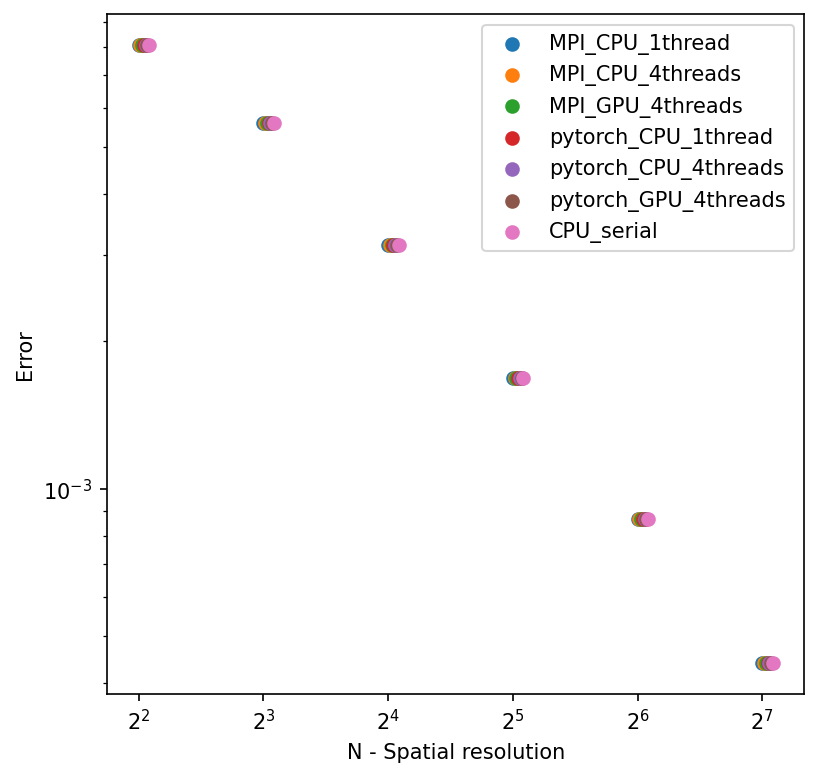

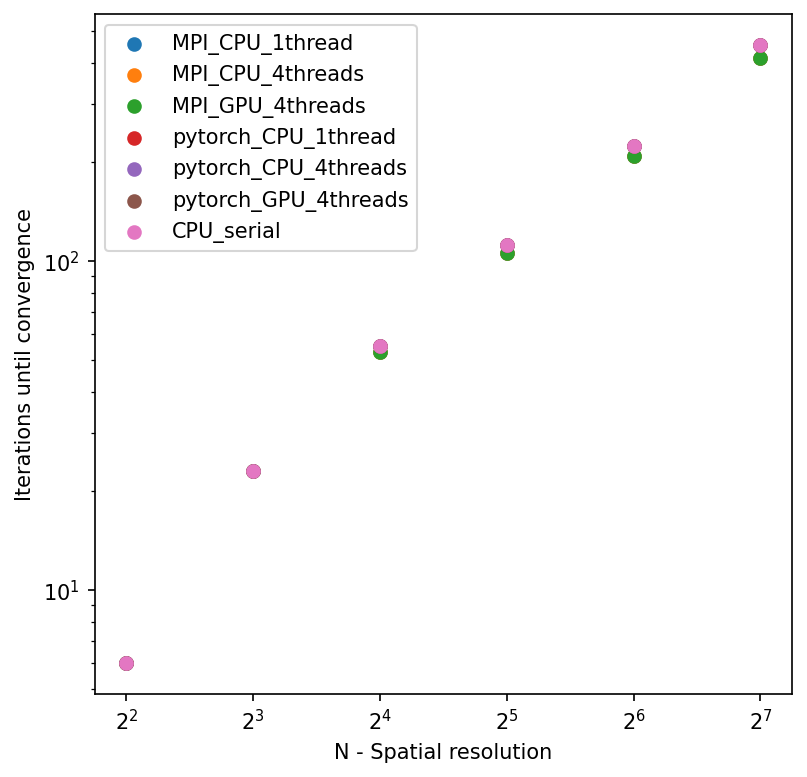

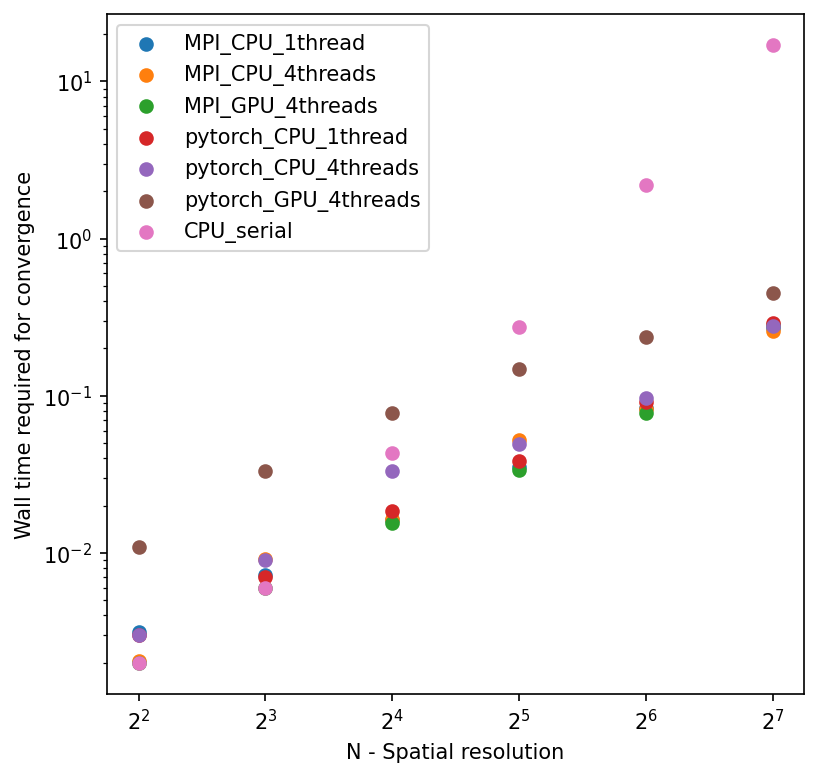

In [7]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)
para = [ 'MPI_CPU_1thread','MPI_CPU_4threads','MPI_GPU_4threads', 'pytorch_CPU_1thread', 'pytorch_CPU_4threads','pytorch_GPU_4threads', 'CPU_serial']
for i, err in enumerate(error_all):
    fig1.gca().scatter(np.array(resolution)*(1+0.01*i), err, label=para[i])
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution, iter, label=para[i])
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")

for i, _wall_time in enumerate(wall_time_all):
    axes3.scatter(resolution, _wall_time, label=para[i])
    axes3.set_yscale("log", base=10)
    axes3.set_xscale("log", base=2)
    axes3.set_xlabel("N - Spatial resolution")
    axes3.set_ylabel("Wall time required for convergence")
    # 擬合曲線



res = np.linspace(resolution[0], resolution[-1], 1000)
#fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
# fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
# fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
# fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
# fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()

#### CG vs other algorithm

In [ ]:
schemes = [ "Jacobi", "Gauss-Seidel", "SOR","CG"]
resolution = np.array([4, 8, 16, 32, 64, 128])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:
    

    error = []
    iters = []
    wall_time = []
    for N in resolution:
        poisson = Poisson2D(N=N)

        x = poisson.x
        ref = ref_func(x[:, None], x[None, :])        
        BC = np.zeros((N+2, N+2))
        BC[-1, 1:-1] = x*(1-x)
        source = source_term(x[:, None], x[None, :])
        if scheme=="SOR":
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=BC, source=source, w=1.6905, terminate=1e-12)
            t2 = time.time()
        else:
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=BC, source=source, terminate=1e-12)
            t2 = time.time()

        error.append(np.abs(poisson.u[1:-1, 1:-1]-ref).sum()/N**2)
        print(error)
        iters.append(poisson.steps)
        wall_time.append(t2-t1)

    error_all.append(error)
    iters_all.append(iters)
    wall_time_all.append(wall_time)


[0.008056640628192606]
[0.008056640628192606, 0.005581531003404808]
[0.008056640628192606, 0.005581531003404808, 0.0031432681773260196]
[0.008056640628192606, 0.005581531003404808, 0.0031432681773260196, 0.0016791312529597208]
[0.008056640628192606, 0.005581531003404808, 0.0031432681773260196, 0.0016791312529597208, 0.000866171948128635]
[0.008056640628192606, 0.005581531003404808, 0.0031432681773260196, 0.0016791312529597208, 0.000866171948128635, 0.0004401283963338451]
[0.008056640625979213]
[0.008056640625979213, 0.005581530992686176]
[0.008056640625979213, 0.005581530992686176, 0.0031432680846798853]
[0.008056640625979213, 0.005581530992686176, 0.0031432680846798853, 0.0016791304950366647]
[0.008056640625979213, 0.005581530992686176, 0.0031432680846798853, 0.0016791304950366647, 0.0008661657113647379]
[0.008056640625979213, 0.005581530992686176, 0.0031432680846798853, 0.0016791304950366647, 0.0008661657113647379, 0.0004400783285454758]
[0.008056640625384547]
[0.008056640625384547, 

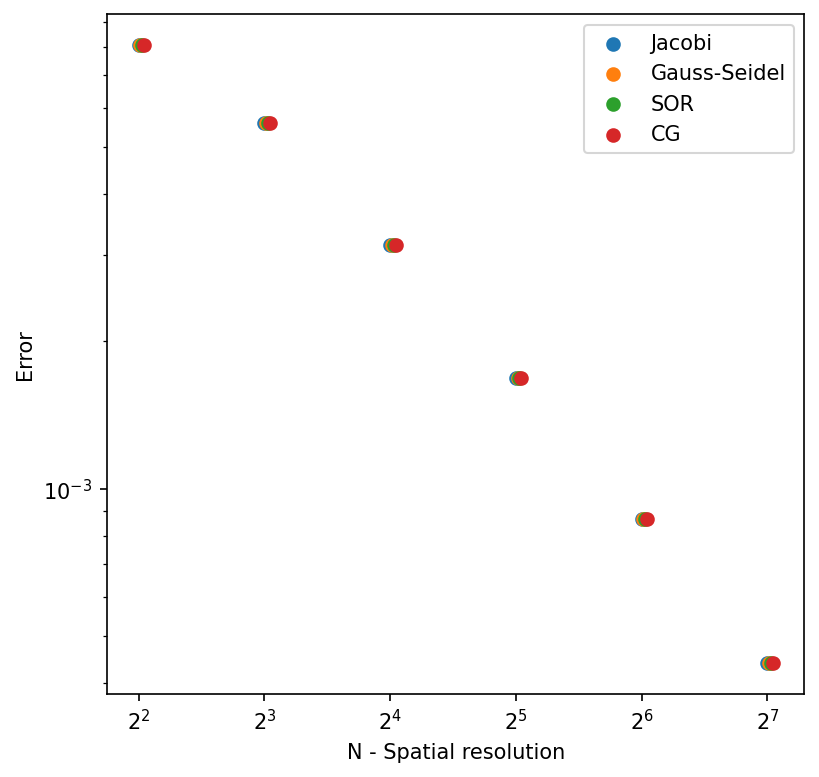

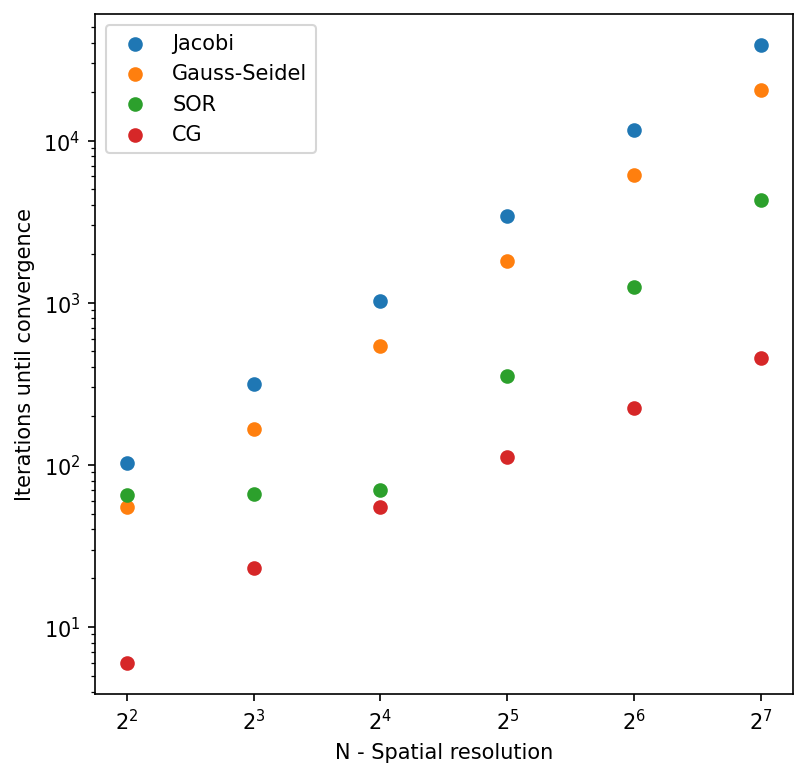

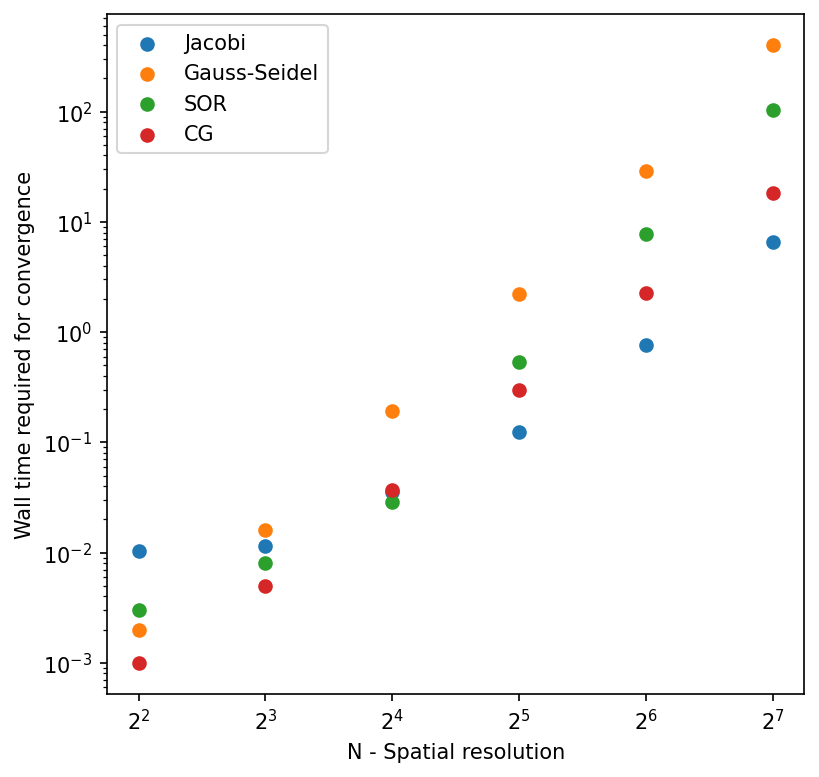

In [ ]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)
para = ["Jacobi", "Gauss-Seidel", "SOR","CG"]
for i, err in enumerate(error_all):
    fig1.gca().scatter(np.array(resolution)*(1+0.01*i), err, label=para[i])
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution, iter, label=para[i])
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")

for i, _wall_time in enumerate(wall_time_all):
    fig3.gca().scatter(resolution, _wall_time, label=para[i])
    fig3.gca().set_yscale("log", base=10)
    fig3.gca().set_xscale("log", base=2)
    fig3.gca().set_xlabel("N - Spatial resolution")
    fig3.gca().set_ylabel("Wall time required for convergence")


res = np.linspace(resolution[0], resolution[-1], 1000)
#fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
# fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
# fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
# fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
# fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()